# Useful function for generating xtable

In [1]:
print.summary.lm.xtable <- function (x, digits = max(3, getOption("digits") - 3), symbolic.cor = x$symbolic.cor, 
    signif.stars = getOption("show.signif.stars"), ...) 
{

if(!require(xtable)) stop("This function requires the package 'xtable' - please make sure you get it")


cat("\\begin{verbatim}")

    cat("\nCall:\n", paste(deparse(x$call), sep = "\n", collapse = "\n"), 
        "\n\n", sep = "")
    resid <- x$residuals
    df <- x$df
    rdf <- df[2L]
    cat(if (!is.null(x$w) && diff(range(x$w))) 
        "Weighted ", "Residuals:\n", sep = "")
    if (rdf > 5L) {
        nam <- c("Min", "1Q", "Median", "3Q", "Max")
        rq <- if (length(dim(resid)) == 2L) 
            structure(apply(t(resid), 1L, quantile), dimnames = list(nam, 
                dimnames(resid)[[2L]]))
        else {
            zz <- zapsmall(quantile(resid), digits + 1)
            structure(zz, names = nam)
        }
        print(rq, digits = digits, ...)
    }
    else if (rdf > 0L) {
        print(resid, digits = digits, ...)
    }
    else {
        cat("ALL", df[1L], "residuals are 0: no residual degrees of freedom!\n")
    }

cat("\\end{verbatim}")

print(xtable(x),   latex.environments = "left") # x is a summary of some lm object

cat("\\begin{verbatim}")
    cat("Residual standard error:", format(signif(x$sigma, 
        digits)), "on", rdf, "degrees of freedom\n")
    if (nzchar(mess <- naprint(x$na.action))) 
        cat("  (", mess, ")\n", sep = "")
    if (!is.null(x$fstatistic)) {
        cat("Multiple R-squared:", formatC(x$r.squared, digits = digits))
        cat(",\tAdjusted R-squared:", formatC(x$adj.r.squared, 
            digits = digits), "\nF-statistic:", formatC(x$fstatistic[1L], 
            digits = digits), "on", x$fstatistic[2L], "and", 
            x$fstatistic[3L], "DF,  p-value:", format.pval(pf(x$fstatistic[1L], 
                x$fstatistic[2L], x$fstatistic[3L], lower.tail = FALSE), 
                digits = digits), "\n")
    }
    correl <- x$correlation
    if (!is.null(correl)) {
        p <- NCOL(correl)
        if (p > 1L) {
            cat("\nCorrelation of Coefficients:\n")
            if (is.logical(symbolic.cor) && symbolic.cor) {
                print(symnum(correl, abbr.colnames = NULL))
            }
            else {
                correl <- format(round(correl, 2), nsmall = 2, 
                  digits = digits)
                correl[!lower.tri(correl)] <- ""
                print(correl[-1, -p, drop = FALSE], quote = FALSE)
            }
        }
    }
    cat("\n")
cat("\\end{verbatim}")
    invisible(x)
}

# Relevant Packages

- `ggplot2` for visualization
- `olsrr` for ols_step_all_possible() function

In [103]:
# install.packages("car", repos = "http://cran.us.r-project.org") 
# install.packages("ggplot2", repos = "http://cran.us.r-project.org")
# install.packages("ppcor", repos = "http://cran.us.r-project.org") 
# install.packages("olsrr", repos = "http://cran.us.r-project.org") 
# install.packages("GGally", repos = "http://cran.us.r-project.org") 
# install.packages("grid", repos = "http://cran.us.r-project.org") 
# install.packages("gridExtra", repos = "http://cran.us.r-project.org") 
# install.packages("DT", repos = "http://cran.us.r-project.org") 
install.packages("texreg", repos = "http://cran.us.r-project.org") 
# install.packages("s", repos = "http://cran.us.r-project.org") 

Installing package into 'C:/Users/emara/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'texreg' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\emara\AppData\Local\Temp\Rtmp6fv4O1\downloaded_packages


# Load libraries and dataset

In [2]:
library(ggplot2)
library(datasets)
library(DT)
library(xtable)
library(texreg)

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'DT' was built under R version 3.4.4"Warning message:
"package 'xtable' was built under R version 3.4.4"Warning message:
"package 'texreg' was built under R version 3.4.4"Version:  1.36.23
Date:     2017-03-03
Author:   Philip Leifeld (University of Glasgow)

Please cite the JSS article in your publications -- see citation("texreg").


In [3]:
data(LifeCycleSavings)

# Understanding the dataset

We will first look at the description to understand to get an intuitive understanding of the dataset. Then we will examine the data types of each column in the dataframe. 

In [4]:
help(LifeCycleSavings)

At the very least, we now know that the target variable is `sr`, which stands for the aggregated *savings ratio* of citizens in a  country. After some quick googling, we can easily find a formal definition 

\begin{equation*} 
savingsRatio = \frac{amountSaved}{disposableIncome} 
\end{equation*}

The explanatory variables are `pop15`, `pop75`, `dpi` and `ddpi`.

- `dpi` stands for *disposable income*, which is defined as *income remaining after deduction of taxes and social security charges, available to be spent or saved as one wishes*
- `ddpi` is the percentage of growth of *disposable income* over 40 years
- `pop15` stands for percentage of population under the age of 15
- `pop75` stands for percentage of population over the age of 75

In [4]:
str(LifeCycleSavings)

'data.frame':	50 obs. of  5 variables:
 $ sr   : num  11.43 12.07 13.17 5.75 12.88 ...
 $ pop15: num  29.4 23.3 23.8 41.9 42.2 ...
 $ pop75: num  2.87 4.41 4.43 1.67 0.83 2.85 1.34 0.67 1.06 1.14 ...
 $ dpi  : num  2330 1508 2108 189 728 ...
 $ ddpi : num  2.87 3.93 3.82 0.22 4.56 2.43 2.67 6.51 3.08 2.8 ...


Target variable and explanatory variables are all `numeric` type. This is great because it means we do not need to handle categorical variables.

In [5]:
# Take a look at the first few rows of the dataframe
head(LifeCycleSavings)

,sr,pop15,pop75,dpi,ddpi
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56
Canada,8.79,31.72,2.85,2982.88,2.43


In [6]:
# Take a look at the numbers in each column
LifeCycleSavings[,1]
LifeCycleSavings[,2]
LifeCycleSavings[,3]
LifeCycleSavings[,4]
LifeCycleSavings[,5]

[1] 11.43 12.07 13.17  5.75 12.88  8.79  0.60 11.90  4.98 10.78 16.85  3.59
[13] 11.24 12.64 12.55 10.67  3.01  7.70  1.27  9.00 11.34 14.28 21.10  3.98
[25] 10.35 15.48 10.25 14.65 10.67  7.30  4.44  2.02 12.70 12.78 12.49 11.14
[37] 13.30 11.77  6.86 14.13  5.13  2.81  7.81  7.56  9.22 18.56  7.72  9.24
[49]  8.89  4.71

[1] 29.35 23.32 23.80 41.89 42.19 31.72 39.74 44.75 46.64 47.64 24.42 46.31
[13] 27.84 25.06 23.31 25.62 46.05 47.32 34.03 41.31 31.16 24.52 27.01 41.74
[25] 21.80 32.54 25.95 24.71 32.61 45.04 43.56 41.18 44.19 46.26 28.96 31.94
[37] 31.92 27.74 21.44 23.49 43.42 46.12 23.27 29.81 46.40 45.25 41.12 28.13
[49] 43.69 47.20

[1] 2.87 4.41 4.43 1.67 0.83 2.85 1.34 0.67 1.06 1.14 3.93 1.19 2.37 4.70 3.35
[16] 3.10 0.87 0.58 3.08 0.96 4.19 3.48 1.91 0.91 3.73 2.47 3.67 3.25 3.17 1.21
[31] 1.20 1.05 1.28 1.12 2.85 2.28 1.52 2.87 4.54 3.73 1.08 1.21 4.46 3.43 0.90
[46] 0.56 1.73 2.72 2.07 0.66

[1] 2329.68 1507.99 2108.47  189.13  728.47 2982.88  662.86  289.52  276.65
[10]  471.24 2496.53  287.77 1681.25 2213.82 2457.12  870.85  289.71  232.44
[19] 1900.10   88.94 1139.95 1390.00 1257.28  207.68 2449.39  601.05 2231.03
[28] 1740.70 1487.52  325.54  568.56  220.56  400.06  152.01  579.51  651.11
[37]  250.96  768.79 3299.49 2630.96  389.66  249.87 1813.93 4001.89  813.39
[46]  138.33  380.47  766.54  123.58  242.69

[1]  2.87  3.93  3.82  0.22  4.56  2.43  2.67  6.51  3.08  2.80  3.99  2.19
[13]  4.32  4.52  3.44  6.28  1.48  3.19  1.12  1.54  2.99  3.54  8.21  5.81
[25]  1.57  8.12  3.62  7.66  1.76  2.48  3.61  1.03  0.67  2.00  7.48  2.19
[37]  2.00  4.35  3.01  2.70  2.96  1.13  2.01  2.45  0.53  5.14 10.23  1.88
[49] 16.71  5.08

No `NaN` or 'weird' numbers at this point, good sign.

# Initial Data Analysis

We will start exploring the data by looking at the scatter plot. 

Warning message:
"package 'GGally' was built under R version 3.4.4"

png 
  2

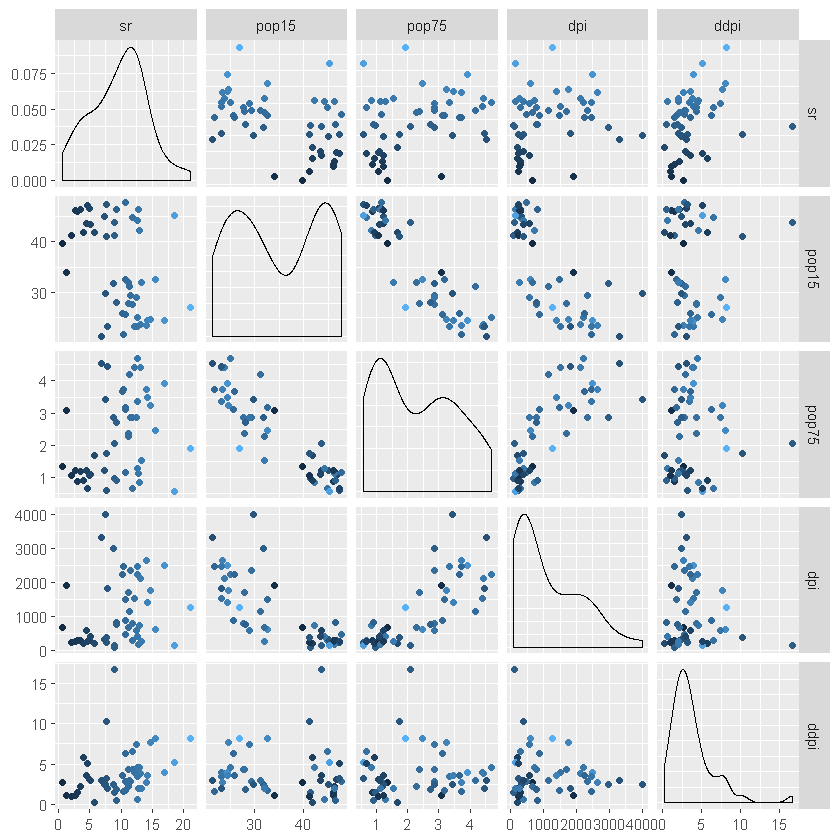

In [8]:
# bivariate relations

# using base graphics
# pairs( ~ sr + pop15 + pop75 + dpi + ddpi, data=LifeCycleSavings)

# using ggally
library(GGally)
ggpairs(LifeCycleSavings, mapping = aes(color = sr), upper=list(continuous = "points", combo = "box"))

# Saving the plot
pdf("LifeCycleSavings_scatterMatrix.pdf", height = 7, width = 7)
plot = ggpairs(LifeCycleSavings, mapping = aes(color = sr), upper=list(continuous = "points", combo = "box"))
print(plot)
dev.off()

We can easily spot a strong negative correlation between `pop15` and `pop75`. Is this intuitive? Yes! If a country has high proportion of citizens above the age of 75, it makes sense that the birth rates will be low.

How strong is it? Let's look at the variance-covariance and correlation matrices.

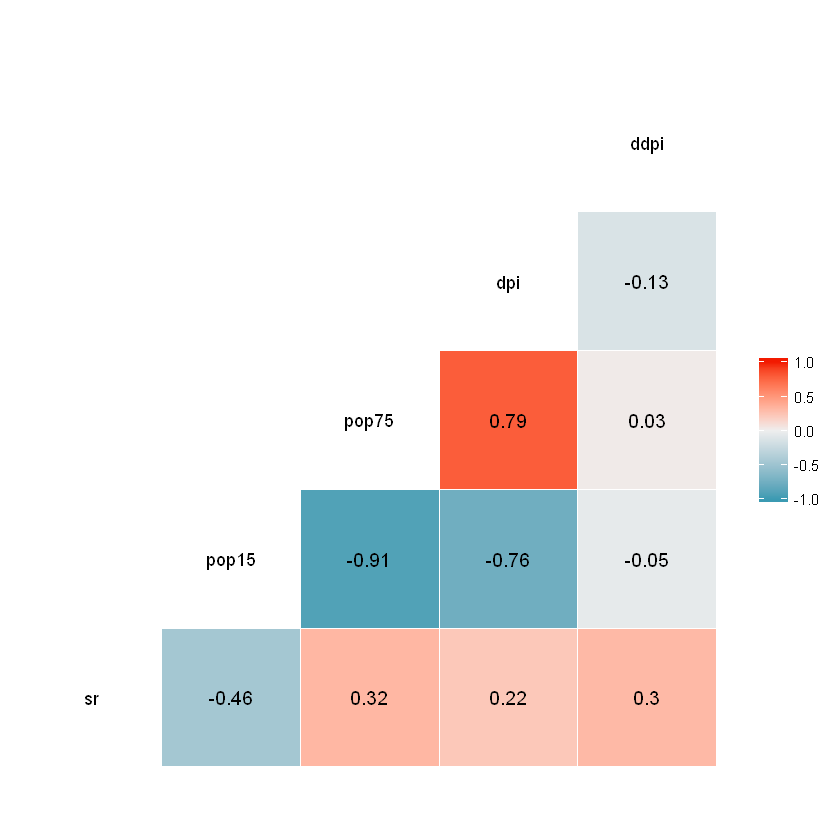

In [9]:
# cov(LifeCycleSavings[c(1,2,3,4,5)])
# cor(LifeCycleSavings[c(1,2,3,4,5)])

# using ggplot2
ggcorr(LifeCycleSavings[c(1,2,3,4,5)], palette = "RdGy", label = TRUE, label_round = 2)

# Saving the plot
# pdf("LifeCycleSavings_correlationMatrix.pdf", height = 7, width = 7)
# plot = ggcorr(LifeCycleSavings[c(1,2,3,4,5)], palette = "RdGy", label = TRUE, label_round = 2)
# print(plot)
# dev.off()

Indeed, `pop15` and `pop75` has a negative correlation of -0.91. 
There seems to be a strong correlation between `pop75` and `dpi` as well. This also makes sense intuitively. 

Now, we move on to looking at the partial correlation matrix.

In [24]:
ppcor::pcor(LifeCycleSavings[c(1,2,3,4,5)])$estimate

# for xtable format in latex
print(xtable(ppcor::pcor(LifeCycleSavings[c(1,2,3,4,5)])$estimate))
print(xtable(cor(LifeCycleSavings[c(1,2,3,4,5)])))

,sr,pop15,pop75,dpi,ddpi
sr,1.00000000,-0.42928891,-0.2266447,-0.05386004,0.29722011
pop15,-0.42928891,1.00000000,-0.7705525,-0.18537256,0.03923169
pop75,-0.22664467,-0.77055252,1.0000000,0.34476850,0.11825311
dpi,-0.05386004,-0.18537256,0.3447685,1.00000000,-0.22757638
ddpi,0.29722011,0.03923169,0.1182531,-0.22757638,1.00000000


% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:47:01 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrr}
  \hline
 & sr & pop15 & pop75 & dpi & ddpi \\ 
  \hline
sr & 1.00 & -0.43 & -0.23 & -0.05 & 0.30 \\ 
  pop15 & -0.43 & 1.00 & -0.77 & -0.19 & 0.04 \\ 
  pop75 & -0.23 & -0.77 & 1.00 & 0.34 & 0.12 \\ 
  dpi & -0.05 & -0.19 & 0.34 & 1.00 & -0.23 \\ 
  ddpi & 0.30 & 0.04 & 0.12 & -0.23 & 1.00 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:47:01 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrr}
  \hline
 & sr & pop15 & pop75 & dpi & ddpi \\ 
  \hline
sr & 1.00 & -0.46 & 0.32 & 0.22 & 0.30 \\ 
  pop15 & -0.46 & 1.00 & -0.91 & -0.76 & -0.05 \\ 
  pop75 & 0.32 & -0.91 & 1.00 & 0.79 & 0.03 \\ 
  dpi & 0.22 & -0.76 & 0.79 & 1.00 & -0.13 \\ 
  ddpi & 0.30 & -0.05 & 0.03 & -0.13 & 1.00 \\ 
   \hline
\end{tabular}
\end{table}


# Modeling

### Models with first order terms only

In [11]:
models = new.env()

# linear model
models.baseline <- lm(sr ~ pop15 + pop75 + dpi + ddpi, data = LifeCycleSavings)
summary(models.baseline)

# for xtable format in latex
print.summary.lm.xtable(summary(models.baseline))


Call:
lm(formula = sr ~ pop15 + pop75 + dpi + ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2422 -2.6857 -0.2488  2.4280  9.7509 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 28.5660865  7.3545161   3.884 0.000334 ***
pop15       -0.4611931  0.1446422  -3.189 0.002603 ** 
pop75       -1.6914977  1.0835989  -1.561 0.125530    
dpi         -0.0003369  0.0009311  -0.362 0.719173    
ddpi         0.4096949  0.1961971   2.088 0.042471 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.803 on 45 degrees of freedom
Multiple R-squared:  0.3385,	Adjusted R-squared:  0.2797 
F-statistic: 5.756 on 4 and 45 DF,  p-value: 0.0007904


\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + pop75 + dpi + ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2422 -2.6857 -0.2488  2.4280  9.7509 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:34:52 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 28.5661 & 7.3545 & 3.88 & 0.0003 \\ 
  pop15 & -0.4612 & 0.1446 & -3.19 & 0.0026 \\ 
  pop75 & -1.6915 & 1.0836 & -1.56 & 0.1255 \\ 
  dpi & -0.0003 & 0.0009 & -0.36 & 0.7192 \\ 
  ddpi & 0.4097 & 0.1962 & 2.09 & 0.0425 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.803 on 45 degrees of freedom
Multiple R-squared: 0.3385,	Adjusted R-squared: 0.2797 
F-statistic: 5.756 on 4 and 45 DF,  p-value: 0.0007904 

\end{verbatim}

In [12]:
# backward elimination on baseline
models.baseline_backward <- step(models.baseline, direction = 'backward')

Start:  AIC=138.3
sr ~ pop15 + pop75 + dpi + ddpi

        Df Sum of Sq    RSS    AIC
- dpi    1     1.893 652.61 136.45
<none>               650.71 138.30
- pop75  1    35.236 685.95 138.94
- ddpi   1    63.054 713.77 140.93
- pop15  1   147.012 797.72 146.49

Step:  AIC=136.45
sr ~ pop15 + pop75 + ddpi

        Df Sum of Sq    RSS    AIC
<none>               652.61 136.45
- pop75  1    47.946 700.55 137.99
- ddpi   1    73.562 726.17 139.79
- pop15  1   145.789 798.40 144.53


In [20]:
# forward selection on baseline
models.baseline_forward = step(lm(sr ~ 1, data=LifeCycleSavings), direction='forward', scope=~ pop15 + pop75 + dpi + ddpi)

print.summary.lm.xtable(summary(models.baseline_forward))

Start:  AIC=150.96
sr ~ 1

        Df Sum of Sq    RSS    AIC
+ pop15  1   204.118 779.51 141.33
+ pop75  1    98.545 885.08 147.68
+ ddpi   1    91.374 892.25 148.09
+ dpi    1    47.763 935.87 150.47
<none>               983.63 150.96

Step:  AIC=141.33
sr ~ pop15

        Df Sum of Sq    RSS    AIC
+ ddpi   1    78.959 700.55 137.99
+ pop75  1    53.343 726.17 139.79
+ dpi    1    35.387 744.12 141.01
<none>               779.51 141.33

Step:  AIC=137.99
sr ~ pop15 + ddpi

        Df Sum of Sq    RSS    AIC
+ pop75  1    47.946 652.61 136.45
<none>               700.55 137.99
+ dpi    1    14.603 685.95 138.94

Step:  AIC=136.45
sr ~ pop15 + ddpi + pop75

       Df Sum of Sq    RSS    AIC
<none>              652.61 136.45
+ dpi   1    1.8932 650.71 138.30
\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + ddpi + pop75, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2539 -2.6159 -0.3913  2.3344  9.7070 
\end{verbatim}% latex table generated in R 3.4.3 

Both forward selection and backward selection returns the same optimal model.

In [14]:
# Compute all possible models
all_possible_first_order_models = olsrr::ols_step_all_possible(models.baseline)
# all_possible_first_order_models

# for xtable format in latex
all_possible_first_order_models = all_possible_first_order_models[ , c("n","predictors", "rsquare", "adjr", "aic", "sbic")]
print(xtable(all_possible_first_order_models))

% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:35:02 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrlrrrr}
  \hline
 & n & predictors & rsquare & adjr & aic & sbic \\ 
  \hline
1 &   1 & pop15 & 0.21 & 0.19 & 285.23 & 143.03 \\ 
  2 &   1 & pop75 & 0.10 & 0.08 & 291.58 & 148.88 \\ 
  4 &   1 & ddpi & 0.09 & 0.07 & 291.98 & 149.26 \\ 
  3 &   1 & dpi & 0.05 & 0.03 & 294.37 & 151.46 \\ 
  7 &   2 & pop15 ddpi & 0.29 & 0.26 & 281.89 & 140.18 \\ 
  5 &   2 & pop15 pop75 & 0.26 & 0.23 & 283.68 & 141.76 \\ 
  6 &   2 & pop15 dpi & 0.24 & 0.21 & 284.90 & 142.84 \\ 
  9 &   2 & pop75 ddpi & 0.19 & 0.15 & 288.42 & 145.94 \\ 
  10 &   2 & dpi ddpi & 0.16 & 0.13 & 290.04 & 147.38 \\ 
  8 &   2 & pop75 dpi & 0.10 & 0.06 & 293.46 & 150.41 \\ 
  12 &   3 & pop15 pop75 ddpi & 0.34 & 0.29 & 280.34 & 139.29 \\ 
  13 &   3 & pop15 dpi ddpi & 0.30 & 0.26 & 282.83 & 141.37 \\ 
  11 &   3 & pop15 pop75 dpi & 0.27 & 0.23 & 284.82 & 143.03 \\ 
  14 &   3 & pop75 dpi ddpi & 0.

In [15]:
# select model with max adjusted r^2, lowest aic, and lowest bic
which.max(all_possible_first_order_models$adjr)
which.min(all_possible_first_order_models$aic)
which.min(all_possible_first_order_models$sbic)

[1] 11

[1] 11

[1] 11

- AIC = −2log(L) + 2K, where K is the number of parameters, L is the likelihood function. 
- BIC = (log(n))k + 2log(L), where n is the number of data points, k is the number of parameters of the model

When we try to maximize all three criteria, we end up with the same model! This is a very good sign that the chosen model is optimal.

In [16]:
all_possible_first_order_models[11, ]

,n,predictors,rsquare,adjr,aic,sbic
12,3,pop15 pop75 ddpi,0.3365317,0.293262,280.3414,139.2874


This is the same as the one we got from backward & forward selection.

In [17]:
models.baseline_optimal = lm(sr ~ (pop15 + pop75 + ddpi), data = LifeCycleSavings)
summary(models.baseline_optimal)

# xtable
print.summary.lm.xtable(summary(models.baseline_optimal))


Call:
lm(formula = sr ~ (pop15 + pop75 + ddpi), data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2539 -2.6159 -0.3913  2.3344  9.7070 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  28.1247     7.1838   3.915 0.000297 ***
pop15        -0.4518     0.1409  -3.206 0.002452 ** 
pop75        -1.8354     0.9984  -1.838 0.072473 .  
ddpi          0.4278     0.1879   2.277 0.027478 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.767 on 46 degrees of freedom
Multiple R-squared:  0.3365,	Adjusted R-squared:  0.2933 
F-statistic: 7.778 on 3 and 46 DF,  p-value: 0.0002646


\begin{verbatim}
Call:
lm(formula = sr ~ (pop15 + pop75 + ddpi), data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2539 -2.6159 -0.3913  2.3344  9.7070 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:35:05 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 28.1247 & 7.1838 & 3.92 & 0.0003 \\ 
  pop15 & -0.4518 & 0.1409 & -3.21 & 0.0025 \\ 
  pop75 & -1.8354 & 0.9984 & -1.84 & 0.0725 \\ 
  ddpi & 0.4278 & 0.1879 & 2.28 & 0.0275 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.767 on 46 degrees of freedom
Multiple R-squared: 0.3365,	Adjusted R-squared: 0.2933 
F-statistic: 7.778 on 3 and 46 DF,  p-value: 0.0002646 

\end{verbatim}

### Models with second order terms

In [18]:
# linear model with interactions
models.second_order_baseline <- lm(sr ~ (pop15 + pop75 + dpi + ddpi)^2, data = LifeCycleSavings)
summary(models.second_order_baseline)

# xtable
print.summary.lm.xtable(summary(models.second_order_baseline))


Call:
lm(formula = sr ~ (pop15 + pop75 + dpi + ddpi)^2, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.8162 -2.9265  0.1388  2.2292  9.6419 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  9.204e+00  1.877e+01   0.490    0.627
pop15       -6.423e-02  3.785e-01  -0.170    0.866
pop75        3.886e+00  4.809e+00   0.808    0.424
dpi          3.200e-04  1.032e-02   0.031    0.975
ddpi         1.126e+00  3.220e+00   0.350    0.728
pop15:pop75 -9.288e-02  1.264e-01  -0.735    0.467
pop15:dpi   -9.644e-07  2.266e-04  -0.004    0.997
pop15:ddpi  -1.151e-02  6.328e-02  -0.182    0.857
pop75:dpi   -8.923e-04  1.460e-03  -0.611    0.545
pop75:ddpi  -2.863e-01  4.313e-01  -0.664    0.511
dpi:ddpi     7.613e-04  7.277e-04   1.046    0.302

Residual standard error: 3.851 on 39 degrees of freedom
Multiple R-squared:  0.412,	Adjusted R-squared:  0.2612 
F-statistic: 2.733 on 10 and 39 DF,  p-value: 0.01195


\begin{verbatim}
Call:
lm(formula = sr ~ (pop15 + pop75 + dpi + ddpi)^2, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.8162 -2.9265  0.1388  2.2292  9.6419 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:35:10 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 9.2038 & 18.7657 & 0.49 & 0.6266 \\ 
  pop15 & -0.0642 & 0.3785 & -0.17 & 0.8661 \\ 
  pop75 & 3.8865 & 4.8090 & 0.81 & 0.4239 \\ 
  dpi & 0.0003 & 0.0103 & 0.03 & 0.9754 \\ 
  ddpi & 1.1263 & 3.2196 & 0.35 & 0.7283 \\ 
  pop15:pop75 & -0.0929 & 0.1264 & -0.73 & 0.4669 \\ 
  pop15:dpi & -0.0000 & 0.0002 & -0.00 & 0.9966 \\ 
  pop15:ddpi & -0.0115 & 0.0633 & -0.18 & 0.8566 \\ 
  pop75:dpi & -0.0009 & 0.0015 & -0.61 & 0.5447 \\ 
  pop75:ddpi & -0.2863 & 0.4313 & -0.66 & 0.5108 \\ 
  dpi:ddpi & 0.0008 & 0.0007 & 1.05 & 0.3020 \\ 
   \hline
\end{tabular}
\end{left

In [19]:
# backward elimination on baseline
models.second_order_baseline_backward_backward <- step(models.second_order_baseline, direction = 'backward')
summary(models.second_order_baseline_backward_backward)

# xtable
print.summary.lm.xtable(summary(models.second_order_baseline_backward_backward))

Start:  AIC=144.41
sr ~ (pop15 + pop75 + dpi + ddpi)^2

              Df Sum of Sq    RSS    AIC
- pop15:dpi    1    0.0003 578.37 142.41
- pop15:ddpi   1    0.4910 578.86 142.45
- pop75:dpi    1    5.5364 583.91 142.89
- pop75:ddpi   1    6.5316 584.90 142.97
- pop15:pop75  1    8.0062 586.38 143.10
- dpi:ddpi     1   16.2285 594.60 143.79
<none>                     578.37 144.41

Step:  AIC=142.41
sr ~ pop15 + pop75 + dpi + ddpi + pop15:pop75 + pop15:ddpi + 
    pop75:dpi + pop75:ddpi + dpi:ddpi

              Df Sum of Sq    RSS    AIC
- pop15:ddpi   1    0.5108 578.88 140.45
- pop75:ddpi   1    6.7381 585.11 140.99
- pop75:dpi    1    8.3861 586.76 141.13
- pop15:pop75  1    9.5161 587.89 141.23
- dpi:ddpi     1   16.4076 594.78 141.81
<none>                     578.37 142.41

Step:  AIC=140.45
sr ~ pop15 + pop75 + dpi + ddpi + pop15:pop75 + pop75:dpi + pop75:ddpi + 
    dpi:ddpi

              Df Sum of Sq    RSS    AIC
- pop75:ddpi   1     6.546 585.43 139.02
- pop15:pop75  1    


Call:
lm(formula = sr ~ pop15 + dpi + ddpi + dpi:ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6393 -2.7889 -0.0436  2.5328 10.7488 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.5287997  4.3729241   3.780 0.000459 ***
pop15       -0.2023669  0.0981090  -2.063 0.044943 *  
dpi         -0.0027411  0.0011774  -2.328 0.024457 *  
ddpi         0.0462479  0.2439993   0.190 0.850521    
dpi:ddpi     0.0008171  0.0003593   2.274 0.027802 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.698 on 45 degrees of freedom
Multiple R-squared:  0.3745,	Adjusted R-squared:  0.3189 
F-statistic: 6.736 on 4 and 45 DF,  p-value: 0.0002452


\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + dpi + ddpi + dpi:ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6393 -2.7889 -0.0436  2.5328 10.7488 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:36:35 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 16.5288 & 4.3729 & 3.78 & 0.0005 \\ 
  pop15 & -0.2024 & 0.0981 & -2.06 & 0.0449 \\ 
  dpi & -0.0027 & 0.0012 & -2.33 & 0.0245 \\ 
  ddpi & 0.0462 & 0.2440 & 0.19 & 0.8505 \\ 
  dpi:ddpi & 0.0008 & 0.0004 & 2.27 & 0.0278 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.698 on 45 degrees of freedom
Multiple R-squared: 0.3745,	Adjusted R-squared: 0.3189 
F-statistic: 6.736 on 4 and 45 DF,  p-value: 0.0002452 

\end{verbatim}

In [58]:
# forward selection on baseline
models.second_order_baseline_forward =
step(lm(sr ~ 1, data=LifeCycleSavings), direction='forward', scope=~ (pop15 + pop75 + dpi + ddpi)^2)
summary(models.second_order_baseline_forward)

# xtable
print.summary.lm.xtable(summary(models.second_order_baseline_forward))

Start:  AIC=150.96
sr ~ 1

        Df Sum of Sq    RSS    AIC
+ pop15  1   204.118 779.51 141.33
+ pop75  1    98.545 885.08 147.68
+ ddpi   1    91.374 892.25 148.09
+ dpi    1    47.763 935.87 150.47
<none>               983.63 150.96

Step:  AIC=141.33
sr ~ pop15

        Df Sum of Sq    RSS    AIC
+ ddpi   1    78.959 700.55 137.99
+ pop75  1    53.343 726.17 139.79
+ dpi    1    35.387 744.12 141.01
<none>               779.51 141.33

Step:  AIC=137.99
sr ~ pop15 + ddpi

             Df Sum of Sq    RSS    AIC
+ pop15:ddpi  1    59.206 641.35 135.58
+ pop75       1    47.946 652.61 136.45
<none>                    700.55 137.99
+ dpi         1    14.603 685.95 138.94

Step:  AIC=135.58
sr ~ pop15 + ddpi + pop15:ddpi

        Df Sum of Sq    RSS    AIC
<none>               641.35 135.58
+ pop75  1   24.4133 616.93 135.64
+ dpi    1    3.8467 637.50 137.28



Call:
lm(formula = sr ~ pop15 + ddpi + pop15:ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5198 -2.2376 -0.1007  2.1628 11.0307 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  7.59867    4.49133   1.692   0.0974 .
pop15       -0.01520    0.11373  -0.134   0.8942  
ddpi         2.59309    1.05993   2.446   0.0183 *
pop15:ddpi  -0.05465    0.02652  -2.061   0.0450 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.734 on 46 degrees of freedom
Multiple R-squared:  0.348,	Adjusted R-squared:  0.3055 
F-statistic: 8.183 on 3 and 46 DF,  p-value: 0.00018


\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + ddpi + pop15:ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5198 -2.2376 -0.1007  2.1628 11.0307 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Sun Apr 08 17:25:25 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 7.5987 & 4.4913 & 1.69 & 0.0974 \\ 
  pop15 & -0.0152 & 0.1137 & -0.13 & 0.8942 \\ 
  ddpi & 2.5931 & 1.0599 & 2.45 & 0.0183 \\ 
  pop15:ddpi & -0.0546 & 0.0265 & -2.06 & 0.0450 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.734 on 46 degrees of freedom
Multiple R-squared: 0.348,	Adjusted R-squared: 0.3055 
F-statistic: 8.183 on 3 and 46 DF,  p-value: 0.00018 

\end{verbatim}

In [55]:
# Computer all possible models
all_possible_second_order_models = olsrr::ols_step_all_possible(models.second_order_baseline)
all_possible_second_order_models

,mindex,n,predictors,rsquare,adjr,predrsq,cp,aic,sbic,sbc,msep,fpe,apc,hsp
10,1,1,dpi:ddpi,0.23376687,0.2178036766,0.16307339,4.8217409,283.5417,140.0370,289.2777,16.35665,16.32992,0.8300859,0.3340818
1,2,1,pop15,0.20751495,0.1910048430,0.14204347,6.5629449,285.2260,141.6036,290.9621,16.91704,16.88940,0.8585255,0.3455278
9,3,1,pop75:ddpi,0.18774609,0.1708241315,0.09028334,7.8741488,286.4580,142.7507,292.1941,17.33904,17.31071,0.8799417,0.3541471
2,4,1,pop75,0.10018562,0.0814394890,0.02633607,13.6817485,291.5768,147.5295,297.3128,19.20818,19.17679,0.9747989,0.3923240
4,5,1,ddpi,0.09289521,0.0739971952,-0.07790383,14.1652976,291.9802,147.9070,297.7163,19.36381,19.33217,0.9826969,0.3955026
3,6,1,dpi,0.04855805,0.0287363452,-0.03452048,17.1060366,294.3663,150.1423,300.1023,20.31027,20.27708,1.0307288,0.4148339
8,7,1,pop75:dpi,0.04752510,0.0276818722,-0.03588849,17.1745490,294.4205,150.1932,300.1566,20.33232,20.29909,1.0318478,0.4152842
5,8,1,pop15:pop75,0.03577439,0.0156863515,-0.05065374,17.9539355,295.0336,150.7683,300.7697,20.58316,20.54952,1.0445777,0.4204076
6,9,1,pop15:dpi,0.01973083,-0.0006914426,-0.06692714,19.0180519,295.8587,151.5428,301.5948,20.92564,20.89144,1.0619583,0.4274027
7,10,1,pop15:ddpi,0.01434686,-0.0061875850,-0.09534970,19.3751535,296.1326,151.8000,301.8686,21.04057,21.00619,1.0677909,0.4297501


OH MY! We iterated through thousands of models! Let's check which of them are the best based on different criteria.

In [56]:
# xtable
all_possible_second_order_models = all_possible_second_order_models[ , c("n","predictors", "rsquare", "adjr", "aic", "sbic")]
print(xtable(all_possible_second_order_models))

% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Sun Apr 08 17:24:28 2018
\begin{table}[ht]
\centering
\begin{tabular}{rrlrrrr}
  \hline
 & n & predictors & rsquare & adjr & aic & sbic \\ 
  \hline
10 &   1 & dpi:ddpi & 0.23 & 0.22 & 283.54 & 140.04 \\ 
  1 &   1 & pop15 & 0.21 & 0.19 & 285.23 & 141.60 \\ 
  9 &   1 & pop75:ddpi & 0.19 & 0.17 & 286.46 & 142.75 \\ 
  2 &   1 & pop75 & 0.10 & 0.08 & 291.58 & 147.53 \\ 
  4 &   1 & ddpi & 0.09 & 0.07 & 291.98 & 147.91 \\ 
  3 &   1 & dpi & 0.05 & 0.03 & 294.37 & 150.14 \\ 
  8 &   1 & pop75:dpi & 0.05 & 0.03 & 294.42 & 150.19 \\ 
  5 &   1 & pop15:pop75 & 0.04 & 0.02 & 295.03 & 150.77 \\ 
  6 &   1 & pop15:dpi & 0.02 & -0.00 & 295.86 & 151.54 \\ 
  7 &   1 & pop15:ddpi & 0.01 & -0.01 & 296.13 & 151.80 \\ 
  37 &   2 & ddpi pop15:ddpi & 0.35 & 0.32 & 277.49 & 134.12 \\ 
  49 &   2 & pop15:dpi dpi:ddpi & 0.33 & 0.30 & 278.83 & 135.31 \\ 
  34 &   2 & dpi dpi:ddpi & 0.32 & 0.29 & 279.91 & 136.29 \\ 
  54 &   2 & pop75:dpi dpi:ddp

In [57]:
# select model with max adjusted r^2, lowest aic, and lowest bic
which.max(all_possible_second_order_models$adjr)
which.min(all_possible_second_order_models$aic)
which.min(all_possible_second_order_models$sbic)

[1] 56

[1] 56

[1] 56

In [23]:
all_possible_second_order_models[56, ]

,mindex,n,predictors,rsquare,adjr,predrsq,cp,aic,sbic,sbc,msep,fpe,apc,hsp
90,56,3,pop15 pop75:dpi dpi:ddpi,0.3827636,0.342509,0.286492,-1.060724,276.7299,133.2859,286.2901,14.35997,14.25438,0.7245819,0.2933001


In [59]:
models.second_order_optimal = lm(sr ~ (pop15 + pop75:dpi + dpi:ddpi), data = LifeCycleSavings)
summary(models.second_order_optimal)

# xtable
print.summary.lm.xtable(summary(models.second_order_optimal))


Call:
lm(formula = sr ~ (pop15 + pop75:dpi + dpi:ddpi), data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2680 -2.5999 -0.0505  2.1913 11.2728 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.7286255  4.3857223   4.042  0.00020 ***
pop15       -0.2420065  0.1008862  -2.399  0.02056 *  
pop75:dpi   -0.0007351  0.0002336  -3.147  0.00290 ** 
dpi:ddpi     0.0007965  0.0002633   3.025  0.00406 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.633 on 46 degrees of freedom
Multiple R-squared:  0.3828,	Adjusted R-squared:  0.3425 
F-statistic: 9.509 on 3 and 46 DF,  p-value: 5.322e-05


\begin{verbatim}
Call:
lm(formula = sr ~ (pop15 + pop75:dpi + dpi:ddpi), data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2680 -2.5999 -0.0505  2.1913 11.2728 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Sun Apr 08 17:25:45 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 17.7286 & 4.3857 & 4.04 & 0.0002 \\ 
  pop15 & -0.2420 & 0.1009 & -2.40 & 0.0206 \\ 
  pop75:dpi & -0.0007 & 0.0002 & -3.15 & 0.0029 \\ 
  dpi:ddpi & 0.0008 & 0.0003 & 3.03 & 0.0041 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.633 on 46 degrees of freedom
Multiple R-squared: 0.3828,	Adjusted R-squared: 0.3425 
F-statistic: 9.509 on 3 and 46 DF,  p-value: 5.322e-05 

\end{verbatim}

### Inspect for collinearity issues

In [63]:
# detect multi-collinearity
require(car)

vif(models.baseline)
vif(models.baseline_optimal)
vif(models.second_order_optimal)

pop15    pop75      dpi     ddpi 
5.937661 6.629105 2.884369 1.074309

pop15    pop75     ddpi 
5.745478 5.736014 1.004186

pop15 pop75:dpi  dpi:ddpi 
 3.164763  3.345982  3.196165

In [64]:
# try excluding one of pop15 and pop75
vif(lm(sr ~ pop15 + pop75 + dpi + ddpi , data=LifeCycleSavings))
vif(lm(sr ~ pop75 + dpi + ddpi , data=LifeCycleSavings))
vif(lm(sr ~ pop15 + dpi + ddpi , data=LifeCycleSavings))

pop15    pop75      dpi     ddpi 
5.937661 6.629105 2.884369 1.074309

pop75      dpi     ddpi 
2.745976 2.791011 1.063029

pop15      dpi     ddpi 
2.459559 2.495779 1.071092

In [65]:
# backward elimination without pop15
models.baseline_without_pop15_backward <-step(lm(sr ~ pop75 + dpi + ddpi, data = LifeCycleSavings))

# xtable
print.summary.lm.xtable(summary(models.baseline_without_pop15_backward))

Start:  AIC=146.49
sr ~ pop75 + dpi + ddpi

        Df Sum of Sq    RSS    AIC
- dpi    1     0.670 798.40 144.53
- pop75  1    26.993 824.72 146.15
<none>               797.72 146.49
- ddpi   1    85.223 882.95 149.56

Step:  AIC=144.53
sr ~ pop75 + ddpi

        Df Sum of Sq    RSS    AIC
<none>               798.40 144.53
- ddpi   1    86.688 885.08 147.68
- pop75  1    93.859 892.25 148.09
\begin{verbatim}
Call:
lm(formula = sr ~ pop75 + ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0223 -3.2949  0.0889  2.4570 10.1069 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Sun Apr 08 17:28:05 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 5.4695 & 1.4101 & 3.88 & 0.0003 \\ 
  pop75 & 1.0726 & 0.4563 & 2.35 & 0.0230 \\ 
  ddpi & 0.4636 & 0.2052 & 2.26 & 0.0286 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbat

In [66]:
# backward elimination without pop75
models.baseline_without_pop75_backward <-step(lm(sr ~ pop15 + dpi + ddpi, data = LifeCycleSavings))
summary(models.baseline_without_pop75_backward)

# xtable
print.summary.lm.xtable(summary(models.baseline_without_pop75_backward))

Start:  AIC=138.94
sr ~ pop15 + dpi + ddpi

        Df Sum of Sq    RSS    AIC
- dpi    1    14.603 700.55 137.99
<none>               685.95 138.94
- ddpi   1    58.175 744.12 141.01
- pop15  1   138.769 824.72 146.15

Step:  AIC=137.99
sr ~ pop15 + ddpi

        Df Sum of Sq    RSS    AIC
<none>               700.55 137.99
- ddpi   1    78.959 779.51 141.33
- pop15  1   191.702 892.25 148.09



Call:
lm(formula = sr ~ pop15 + ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5831 -2.8632  0.0453  2.2273 10.4753 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15.59958    2.33439   6.682 2.48e-08 ***
pop15       -0.21638    0.06033  -3.586 0.000796 ***
ddpi         0.44283    0.19240   2.302 0.025837 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.861 on 47 degrees of freedom
Multiple R-squared:  0.2878,	Adjusted R-squared:  0.2575 
F-statistic: 9.496 on 2 and 47 DF,  p-value: 0.0003438


\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + ddpi, data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5831 -2.8632  0.0453  2.2273 10.4753 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Sun Apr 08 17:29:23 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 15.5996 & 2.3344 & 6.68 & 0.0000 \\ 
  pop15 & -0.2164 & 0.0603 & -3.59 & 0.0008 \\ 
  ddpi & 0.4428 & 0.1924 & 2.30 & 0.0258 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.861 on 47 degrees of freedom
Multiple R-squared: 0.2878,	Adjusted R-squared: 0.2575 
F-statistic: 9.496 on 2 and 47 DF,  p-value: 0.0003438 

\end{verbatim}

In [78]:
# summary(models.baseline)
# summary(models.baseline_without_pop15_backward)
# summary(models.baseline_without_pop75_backward)
# summary(models.baseline_optimal)
# summary(models.second_order_optimal)

ls_models = list(models.baseline, 
          models.baseline_without_pop15_backward,
          models.baseline_without_pop75_backward,
          models.baseline_optimal,
          models.second_order_optimal
          )

ls_names = c(
            "1stOrderBase",
            "1stOrder w/o pop15",
            "1stOrder w/o pop75 ",
            "1stOrderBest",
            "2ndOrderBest"
            )

print(screenreg(l = ls_models, custom.model.names = ls_names))

# latex format
print(texreg(l = ls_models, custom.model.names = ls_names))


             1stOrderBase  1stOrder w/o pop15  1stOrder w/o pop75   1stOrderBest  2ndOrderBest
----------------------------------------------------------------------------------------------
(Intercept)  28.57 ***      5.47 ***           15.60 ***            28.12 ***     17.73 ***   
             (7.35)        (1.41)              (2.33)               (7.18)        (4.39)      
pop15        -0.46 **                          -0.22 ***            -0.45 **      -0.24 *     
             (0.14)                            (0.06)               (0.14)        (0.10)      
pop75        -1.69          1.07 *                                  -1.84                     
             (1.08)        (0.46)                                   (1.00)                    
dpi          -0.00                                                                            
             (0.00)                                                                           
ddpi          0.41 *        0.46 *              0

# Diagnostics

### baseline_optimal

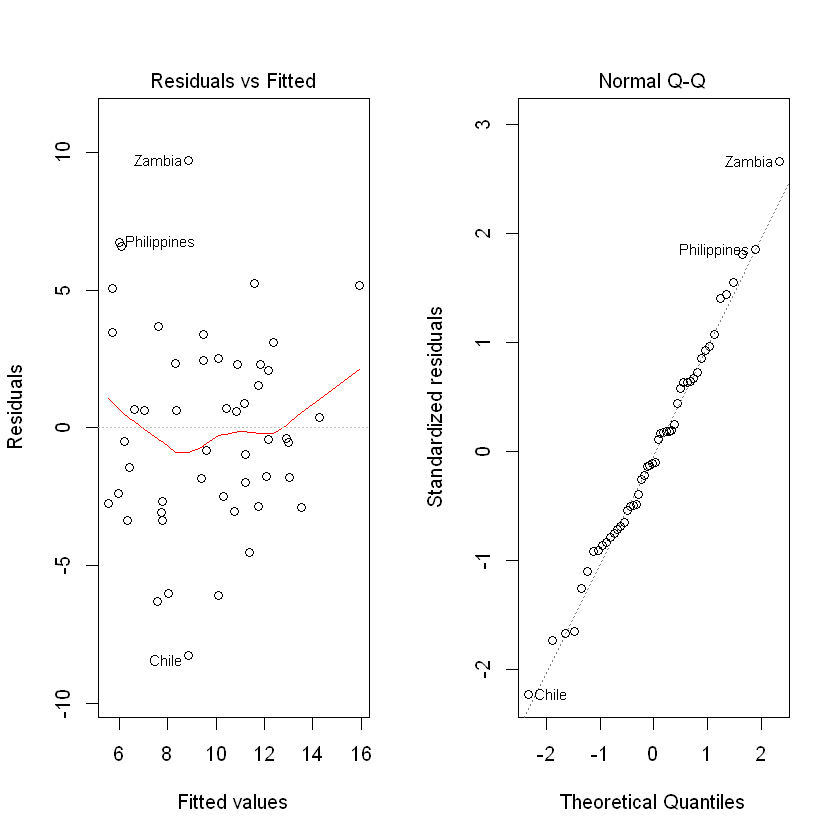

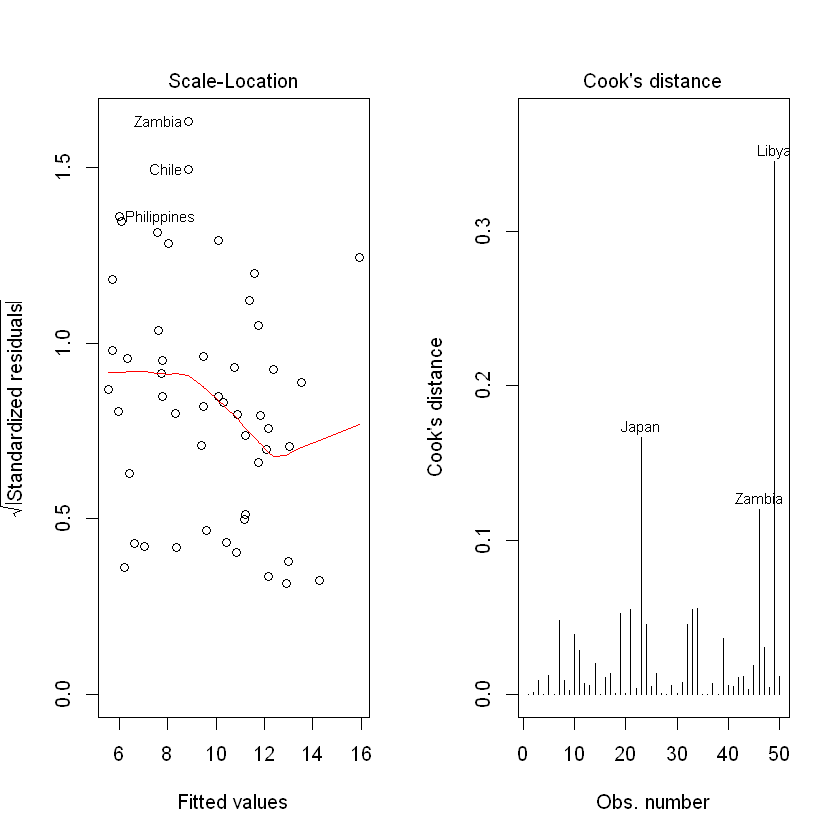

In [84]:
# pdf("LifeCycleSavings_baseline_optimal_diagnostic.pdf", height = 7, width = 7)

layout(matrix(1:2,ncol=2))
plot(models.baseline_optimal, which = 1)
plot(models.baseline_optimal, which = 2)


layout(matrix(1:2,ncol=2))
plot(models.baseline_optimal, which = 3)
plot(models.baseline_optimal, which = 4)

# Saving the plot
# dev.off()

### baseline_without_pop75_backward

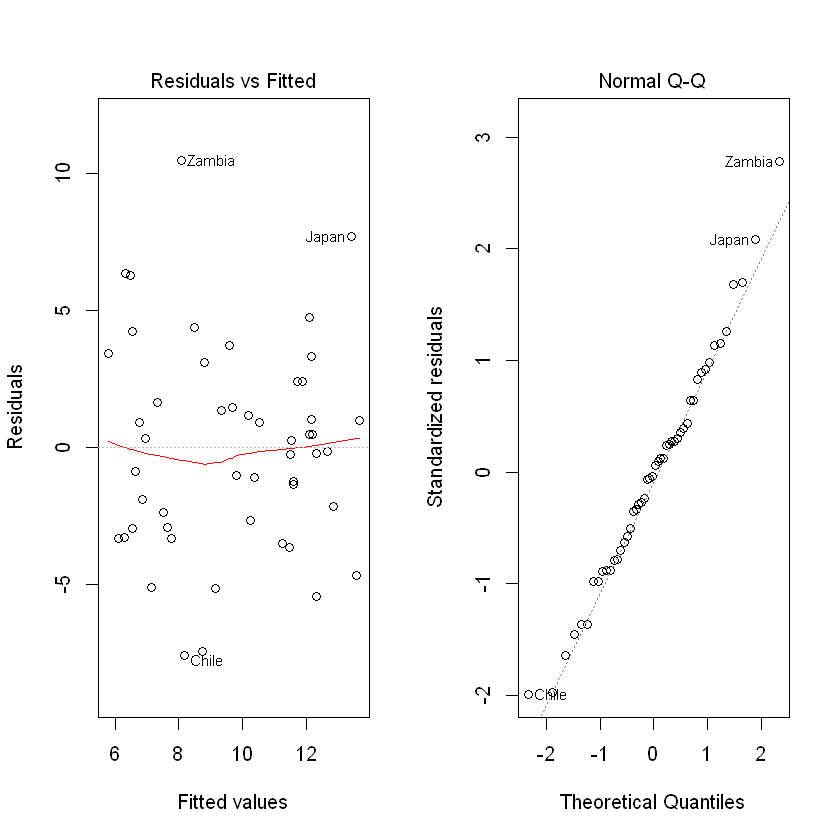

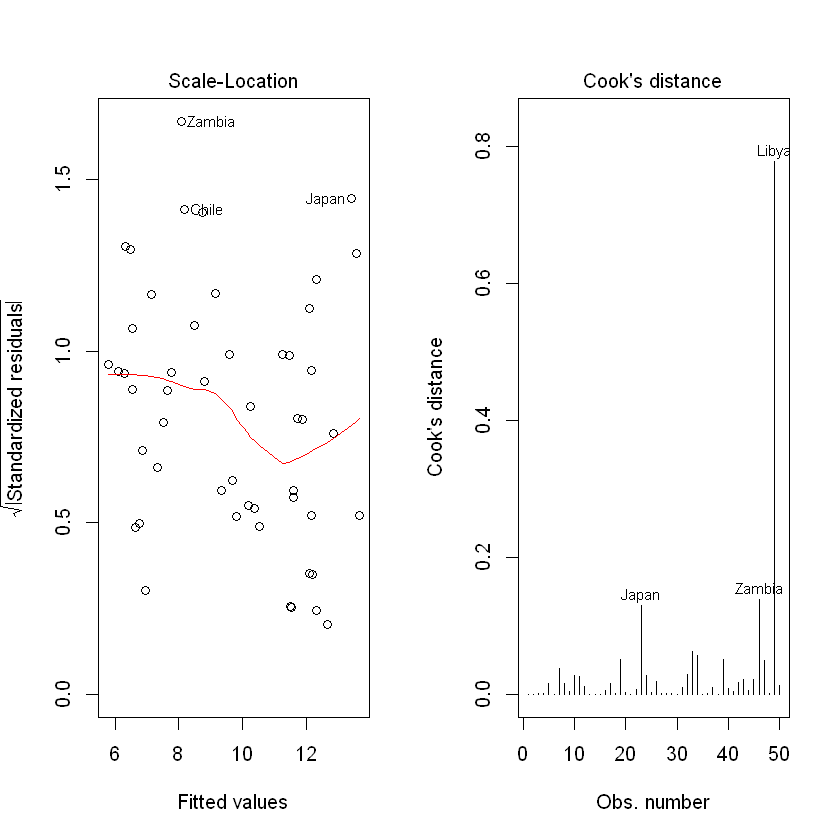

In [83]:
# pdf("LifeCycleSavings_baseline_without_pop75_backward.pdf", height = 7, width = 7)

layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop75_backward, which = 1)
plot(models.baseline_without_pop75_backward, which = 2)
layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop75_backward, which = 3)
plot(models.baseline_without_pop75_backward, which = 4)

# Saving the plot
# dev.off()

### baseline_without_pop15_backward

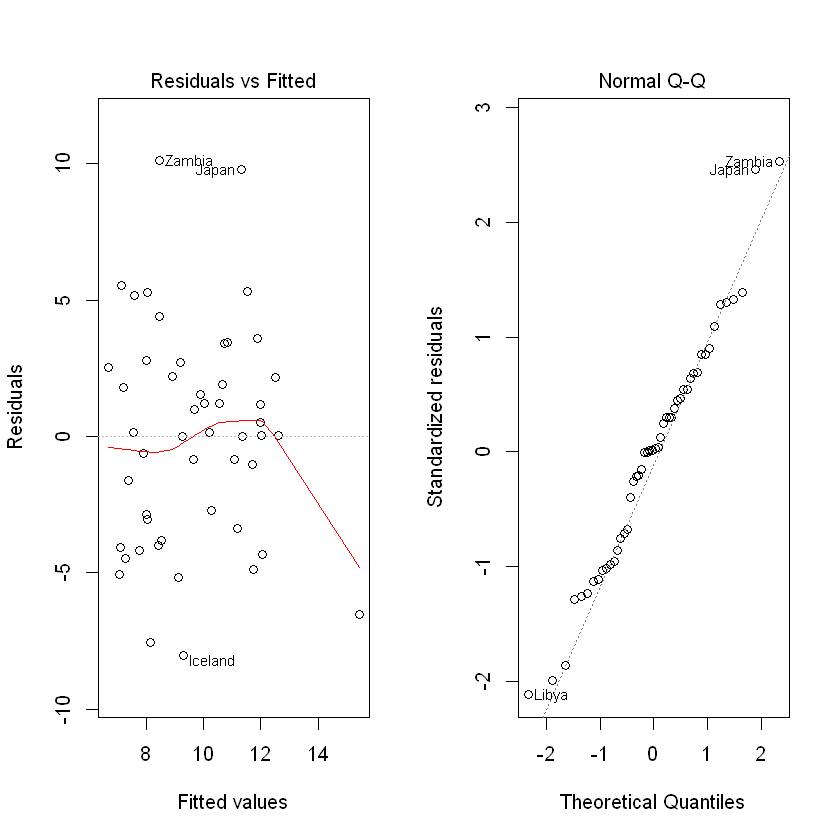

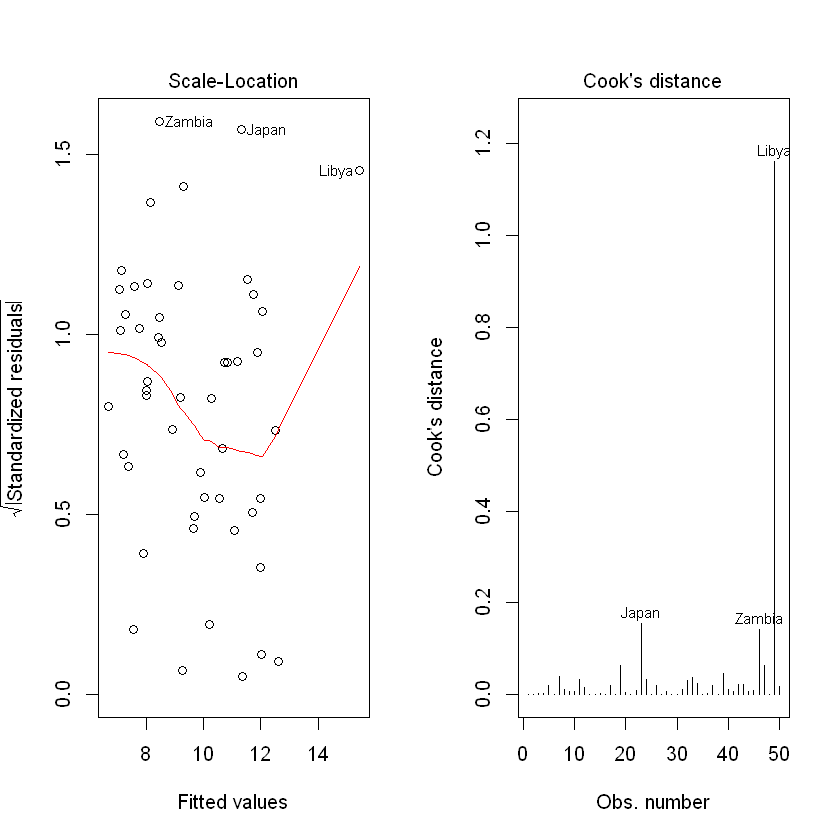

In [86]:
# pdf("LifeCycleSavings_baseline_without_pop15_backward.pdf", height = 7, width = 7)

layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop15_backward, which = 1)
plot(models.baseline_without_pop15_backward, which = 2)
layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop15_backward, which = 3)
plot(models.baseline_without_pop15_backward, which = 4)

# Saving the plot
# dev.off()

### second_order_optimal

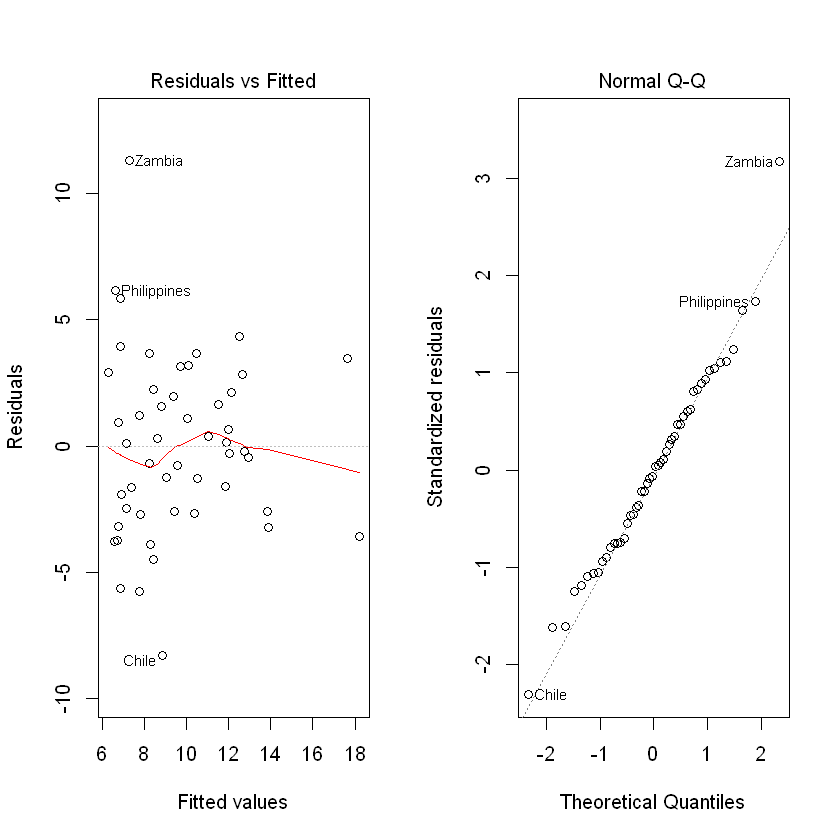

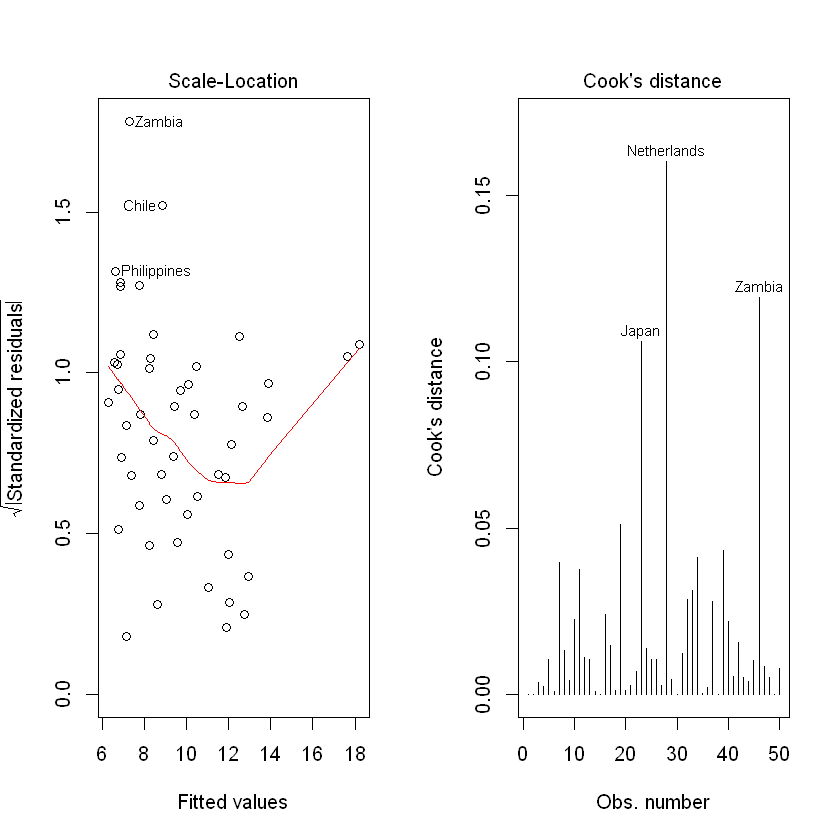

In [88]:
# pdf("LifeCycleSavings_second_order_optimal.pdf", height = 7, width = 7)

layout(matrix(1:2,ncol=2))
plot(models.second_order_optimal, which = 1)
plot(models.second_order_optimal, which = 2)
layout(matrix(1:2,ncol=2))
plot(models.second_order_optimal, which = 3)
plot(models.second_order_optimal, which = 4)

# Saving the plot
# dev.off()

# Remove outliers for baseline_without_pop75_backward

In [25]:
which(rownames(LifeCycleSavings) %in% c("Libya", "Chile", "Zambia", "Japan"))

[1]  7 23 46 49

In [26]:
LifeCycleSavings.without_Libya = LifeCycleSavings[-c(49, 7, 23, 46), ] 

In [27]:
str(LifeCycleSavings.without_Libya)

'data.frame':	46 obs. of  5 variables:
 $ sr   : num  11.43 12.07 13.17 5.75 12.88 ...
 $ pop15: num  29.4 23.3 23.8 41.9 42.2 ...
 $ pop75: num  2.87 4.41 4.43 1.67 0.83 2.85 0.67 1.06 1.14 3.93 ...
 $ dpi  : num  2330 1508 2108 189 728 ...
 $ ddpi : num  2.87 3.93 3.82 0.22 4.56 2.43 6.51 3.08 2.8 3.99 ...


In [28]:
models.baseline_without_pop75_backward_revised = step(lm(sr ~ pop15 + dpi + ddpi, data = LifeCycleSavings.without_Libya))
summary(models.baseline_without_pop75_backward_revised)

print.summary.lm.xtable(summary(models.baseline_without_pop75_backward_revised))

Start:  AIC=112.12
sr ~ pop15 + dpi + ddpi

        Df Sum of Sq    RSS    AIC
- dpi    1     8.817 451.20 111.03
<none>               442.38 112.12
- ddpi   1    29.269 471.65 113.07
- pop15  1   108.783 551.16 120.24

Step:  AIC=111.03
sr ~ pop15 + ddpi

        Df Sum of Sq    RSS    AIC
<none>               451.20 111.03
- ddpi   1    41.132 492.33 113.04
- pop15  1   161.604 612.80 123.11



Call:
lm(formula = sr ~ pop15 + ddpi, data = LifeCycleSavings.without_Libya)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3033 -2.4520  0.1975  1.7263  6.4475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15.15557    2.17175   6.979 1.38e-08 ***
pop15       -0.20835    0.05309  -3.924 0.000309 ***
ddpi         0.45342    0.22901   1.980 0.054140 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.239 on 43 degrees of freedom
Multiple R-squared:  0.3449,	Adjusted R-squared:  0.3144 
F-statistic: 11.32 on 2 and 43 DF,  p-value: 0.0001125


\begin{verbatim}
Call:
lm(formula = sr ~ pop15 + ddpi, data = LifeCycleSavings.without_Libya)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3033 -2.4520  0.1975  1.7263  6.4475 
\end{verbatim}% latex table generated in R 3.4.3 by xtable 1.8-2 package
% Mon Apr 09 03:58:21 2018
\begin{table}[ht]
\begin{left}
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & t value & Pr($>$$|$t$|$) \\ 
  \hline
(Intercept) & 15.1556 & 2.1717 & 6.98 & 0.0000 \\ 
  pop15 & -0.2083 & 0.0531 & -3.92 & 0.0003 \\ 
  ddpi & 0.4534 & 0.2290 & 1.98 & 0.0541 \\ 
   \hline
\end{tabular}
\end{left}
\end{table}
\begin{verbatim}Residual standard error: 3.239 on 43 degrees of freedom
Multiple R-squared: 0.3449,	Adjusted R-squared: 0.3144 
F-statistic: 11.32 on 2 and 43 DF,  p-value: 0.0001125 

\end{verbatim}

In [29]:
pdf("LifeCycleSavings_final_model_without_outliers.pdf", height = 7, width = 7)

layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop75_backward_revised, which = 1)
plot(models.baseline_without_pop75_backward_revised, which = 2)
layout(matrix(1:2,ncol=2))
plot(models.baseline_without_pop75_backward_revised, which = 3)
plot(models.baseline_without_pop75_backward_revised, which = 4)

# Saving the plot
dev.off()

png 
  2

In [ ]:
# 